<a href="https://colab.research.google.com/github/TeeHigh/SCD-Prediction-with-Ensemble-Learning/blob/main/SCDEnsembleModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [ ]:
# Base directory
base_dir = '/content/drive/MyDrive/SCD Detection Dataset'

# Only include these two categories
negative_dir = os.path.join(base_dir, 'Negative', 'Clear')
positive_unlabelled_dir = os.path.join(base_dir, 'Positive', 'Unlabelled')

# Function to load images from a folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        img = cv2.imread(path)
        if img is not None:
            images.append(img)
    return images

# Load and label data
X = []
y = []

# Load negative class (0)
neg_images = load_images_from_folder(negative_dir)
X += neg_images
y += [0] * len(neg_images)

# Load positive (unlabelled) class (1)
pos_images = load_images_from_folder(positive_unlabelled_dir)
X += pos_images
y += [1] * len(pos_images)


In [ ]:
# -----------------------------------
# 2. Preprocessing and Train-Test Split
# -----------------------------------
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array

# Import train_test_split
from sklearn.model_selection import train_test_split

# Load pretrained CNN
base_cnn = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(64, 64, 3))
feature_model = Model(inputs=base_cnn.input, outputs=base_cnn.output)

# CNN-based preprocessing
def extract_cnn_features(images):
    features = []
    for img in images:
        img_resized = cv2.resize(img, (64, 64))
        img_array = img_to_array(img_resized)
        img_array = preprocess_input(img_array)
        img_array = np.expand_dims(img_array, axis=0)
        feature = feature_model.predict(img_array, verbose=0)
        features.append(feature.flatten())
    return np.array(features)

# Extract features and convert labels
X_features = extract_cnn_features(X)
y = np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y, test_size=0.2, stratify=y, random_state=42)


/tmp/ipython-input-5-3791931430.py:13: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_cnn = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(64, 64, 3))


In [ ]:
# -----------------------------------
# 3. Handle Class Imbalance (SMOTE)
# -----------------------------------
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


In [ ]:
# -----------------------------------
# 4. Model Definitions (with class_weight where supported)
# -----------------------------------

# Base models
base_models = [
    ('rf', RandomForestClassifier(n_estimators=150, class_weight='balanced')),
    ('gb', GradientBoostingClassifier()),  # doesn't support class_weight
    ('svm', SVC(probability=True, class_weight='balanced'))
]

# Meta model for stacking
meta_model = LogisticRegression(class_weight='balanced')


In [ ]:
# -----------------------------------
# 5. Train All Models
# -----------------------------------
# Stacking
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)
stacking_model.fit(X_train_balanced, y_train_balanced)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(class_weight='balanced',
                                                       n_estimators=150)),
                               ('gb', GradientBoostingClassifier()),
                               ('svm',
                                SVC(class_weight='balanced',
                                    probability=True))],
                   final_estimator=LogisticRegression(class_weight='balanced'))

In [ ]:
# Boosting
boosting_model = GradientBoostingClassifier(
    n_estimators=300, learning_rate=0.05, max_depth=4,
    subsample=0.8, min_samples_split=5, random_state=42)
boosting_model.fit(X_train_balanced, y_train_balanced)

GradientBoostingClassifier(learning_rate=0.05, max_depth=4, min_samples_split=5,
                           n_estimators=300, random_state=42, subsample=0.8)

In [ ]:
# Voting
voting_model = VotingClassifier(estimators=base_models, voting='soft')
voting_model.fit(X_train_balanced, y_train_balanced)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     n_estimators=150)),
                             ('gb', GradientBoostingClassifier()),
                             ('svm',
                              SVC(class_weight='balanced', probability=True))],
                 voting='soft')

In [ ]:
# Bagging
bagging_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=5),
    n_estimators=100, max_samples=0.8, max_features=0.8, random_state=42)
bagging_model.fit(X_train_balanced, y_train_balanced)

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5),
                  max_features=0.8, max_samples=0.8, n_estimators=100,
                  random_state=42)

In [ ]:
# -----------------------------------
# 6. Function To Evaluate All Models
# -----------------------------------

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{name} Accuracy: {acc:.2f}")
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


Stacking Accuracy: 0.87
              precision    recall  f1-score   support

    Negative       0.75      0.75      0.75        32
    Positive       0.91      0.91      0.91        87

    accuracy                           0.87       119
   macro avg       0.83      0.83      0.83       119
weighted avg       0.87      0.87      0.87       119



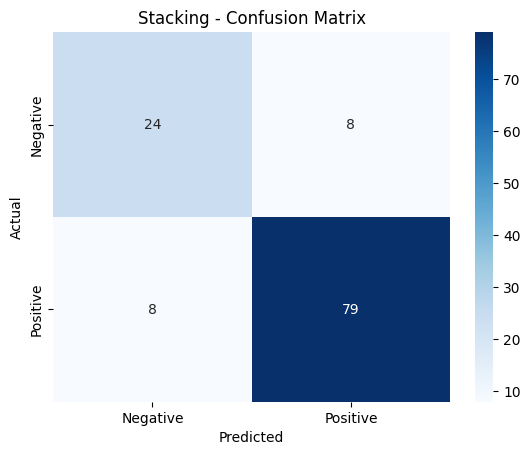


Boosting Accuracy: 0.86
              precision    recall  f1-score   support

    Negative       0.73      0.75      0.74        32
    Positive       0.91      0.90      0.90        87

    accuracy                           0.86       119
   macro avg       0.82      0.82      0.82       119
weighted avg       0.86      0.86      0.86       119



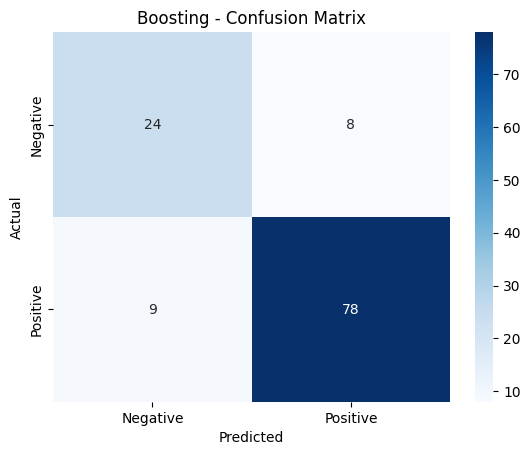


Voting Accuracy: 0.87
              precision    recall  f1-score   support

    Negative       0.75      0.75      0.75        32
    Positive       0.91      0.91      0.91        87

    accuracy                           0.87       119
   macro avg       0.83      0.83      0.83       119
weighted avg       0.87      0.87      0.87       119



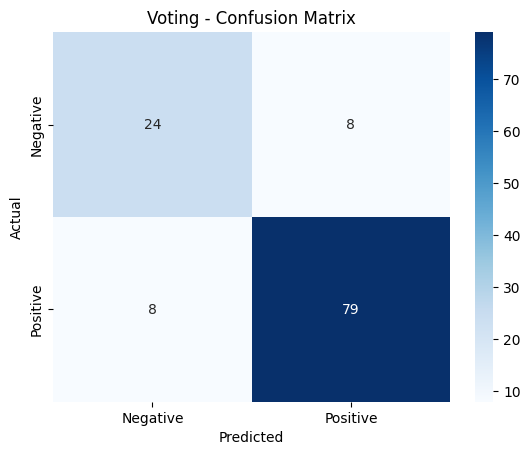


Bagging Accuracy: 0.87
              precision    recall  f1-score   support

    Negative       0.76      0.78      0.77        32
    Positive       0.92      0.91      0.91        87

    accuracy                           0.87       119
   macro avg       0.84      0.84      0.84       119
weighted avg       0.88      0.87      0.87       119



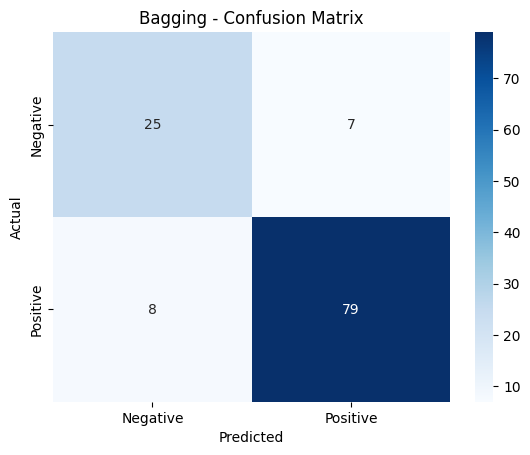

In [ ]:
# -----------------------------------
# 7. Evaluate All Models
# -----------------------------------

evaluate_model("Stacking", stacking_model, X_test, y_test)
evaluate_model("Boosting", boosting_model, X_test, y_test)
evaluate_model("Voting", voting_model, X_test, y_test)
evaluate_model("Bagging", bagging_model, X_test, y_test)

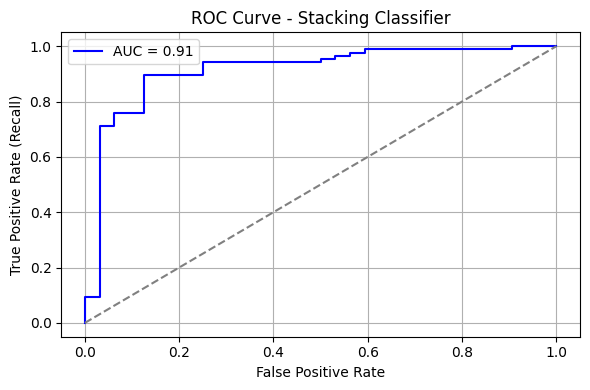

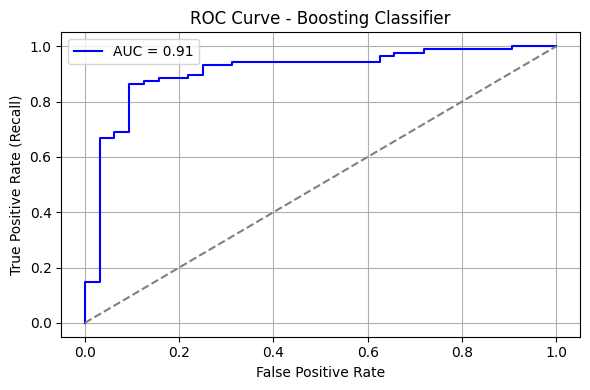

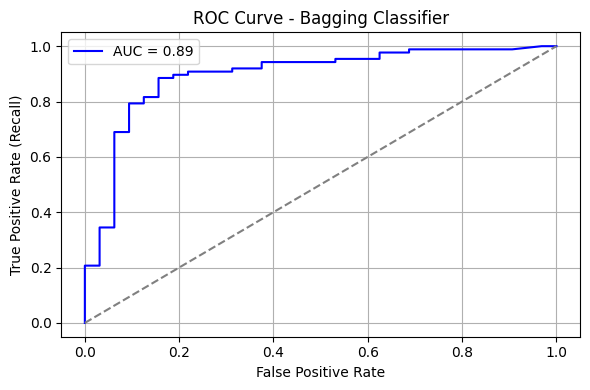

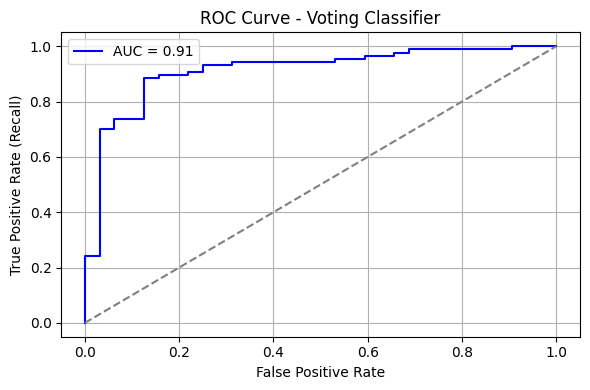

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Dictionary of models
models = {
    'Stacking': stacking_model,
    'Boosting': boosting_model,
    'Bagging': bagging_model,
    'Voting': voting_model
}

# Loop through each model individually
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        # Get probability estimates for class 1 (positive)
        y_probs = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        auc = roc_auc_score(y_test, y_probs)

        # Plot ROC curve
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, color='blue', label=f"AUC = {auc:.2f}")
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.title(f"ROC Curve - {name} Classifier")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate (Recall)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Model {name} does not support predict_proba.")


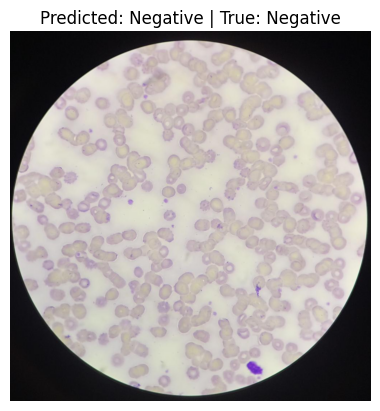

In [ ]:
import random
import cv2
import matplotlib.pyplot as plt

# Pick a random index from your dataset
random_idx = random.randint(0, len(X) - 1)

# Load the image (original size)
image = X[random_idx]
label = y[random_idx]

# Preprocess for CNN feature extraction
img_resized = cv2.resize(image, (64, 64))
img_array = preprocess_input(img_to_array(img_resized))
img_array = np.expand_dims(img_array, axis=0)

# Extract features
cnn_feature = feature_model.predict(img_array, verbose=0)

# Predict using your best model (e.g., stacking_model)
prediction = stacking_model.predict(cnn_feature)

# Display
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
predicted_class = "Positive (SCD)" if prediction[0] == 1 else "Negative"
true_class = "Positive (SCD)" if label == 1 else "Negative"
plt.title(f"Predicted: {predicted_class} | True: {true_class}")
plt.show()
